In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import torch
from input.dataset import DGL
import torch
from torch.utils.data import DataLoader
from main import expand_dataset
import json

Using backend: pytorch


In [2]:
# config_path = 'config/GRAPH23D_ATTENTION.json'
# config_path = 'output/threed_ssg/graphto3d_attention/22_05_04_13h32m06s'
# checkpoint_path = 'output/threed_ssg/graphto3d_attention/22_05_05_21h48m57s'
# config_path = 'config/GRAPHTRANSFORMER.json'
# checkpoint_path = 'output/threed_ssg/graph_transformer/22_05_05_23h08m03s'
config_path = 'config/GRAPHORMER.json'
# checkpoint_path = 'output/threed_ssg/graphormer/GPH/22_05_02_11h40m42s'
checkpoint_path = 'output/threed_ssg/graphormer/GPH/22_05_04_13h22m48s'
dataset_name = 'threed_ssg_full'

In [3]:
with open(config_path) as f:
    config = json.load(f)
    print(f"Configuration file found.")
    params = config['params']
    params["tests"] = config['tests']
    params["normalize_location"] = config['data']["normalize_location"]
    params["normalize_dimension"] = config['data']["normalize_dimension"]
    params["normalize_orientation"] = config['data']["normalize_orientation"]
params['root_dir'] = checkpoint_path
params['device'] = 'cpu'
params['dataset'] = dataset_name
for data_param in config['data']:
    params[data_param] = config['data'][data_param]
params['deterministic'] = False
params['use_prior'] = config['use_prior']
dataset = DGL(dataset_name, params)
dataset = expand_dataset(dataset, params)
params = dataset.params

# load scene
train_set, val_set = dataset.train, dataset.val
train_loader = DataLoader(
        train_set, batch_size=params["batch_size"], shuffle=True, collate_fn=dataset.__getitem__)
val_loader = DataLoader(val_set, batch_size=1,
                            shuffle=False, collate_fn=dataset.__getitem__)

Configuration file found.
Loading dataset(s) threed_ssg_full
Train : 1178
Val : 157
Time LoadData: 1.8427s
Adding Laplacian positional encoding..
Time LapPE: 2.0611s


In [4]:
import csv
relationships_path = 'input/data/threed_ssg/raw/vocab/relationships.tsv'
relationships = csv.reader(open(relationships_path), delimiter="\t")
relation_dict = {}
for row in relationships:
    if row[0] != 'id':
        relation_dict[int(row[0])] = row[1]

In [5]:
def get_dst_locations(g, scores, targets, selected_edge_type):
    score_loc_list, target_loc_list = [], []
    u_s, v_s, eid_s = g.edges(form="all")
    for triplet in zip(u_s, v_s, eid_s):
        u, v, eid = triplet
        edge_feat = g.edata['feat'][eid]
        if edge_feat == selected_edge_type: 
            score_src_loc = scores[u, 3:6]
            score_dst_loc = scores[v, 3:6]
            # compute the location of dst object centered on src object 
            score_loc_list.append(score_dst_loc - score_src_loc)

            target_src_loc = targets[u, 3:6]
            target_dst_loc = targets[v, 3:6]
            target_loc_list.append(target_dst_loc - target_src_loc)
            
    return score_loc_list, target_loc_list

In [6]:
def smoothed_heat_plot(x, y, s, extent, bins=1000):
    range = [[-extent, extent], [-extent, extent]]
    heatmap, xedges, yedges = np.histogram2d(x, y, range = range, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    # extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    return heatmap.T

In [7]:
def scatter_heat_plot(data, extent, title, sigma = 16):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title)
    x, y, z = [], [], []
    for loc in data:
        x.append(loc[0])
        y.append(loc[1])
        z.append(loc[2])

    extent_list = [-extent, extent, -extent, extent]
    
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    ax.set_zlim(-extent, extent)
    ax.scatter3D(x, y, z, c = z)
    ax.set_title("Scatter plot")

    img = smoothed_heat_plot(x, y, sigma, extent)
    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(img, extent=extent_list, origin='lower', cmap=cm.jet)
    ax.set_title("Top-down View")

    img = smoothed_heat_plot(x, z, sigma, extent)
    ax = fig.add_subplot(2, 2, 3)
    ax.imshow(img, extent=extent_list, origin='lower', cmap=cm.jet)
    ax.set_title("Front View")

    img = smoothed_heat_plot(y, z, sigma, extent)
    ax = fig.add_subplot(2, 2, 4)
    ax.imshow(img, extent=extent_list, origin='lower', cmap=cm.jet)
    ax.set_title("Side View")

    plt.show()

In [8]:
from scripts.inference import load_checkpoint, load_statistics
from network.models.model import BubbleBee

# initialize the model
model = BubbleBee(params)
model.eval()

# load checkpoint

check_dir = os.path.join(params['root_dir'], "checkpoints")
model, epoch_nb = load_checkpoint(model, check_dir, device= 'cpu')

# load/compute statistics
if not params["use_prior"]:
    posterior_statistics = load_statistics(
        params['root_dir'], epoch_nb, model, train_loader)
else:
    posterior_statistics = None


Which epoch from the list below you'd like to load the checkpoint?
[0, 24, 49, 74, 99]
Loading trained model of epoch 99...
 Loading train stats from saved posterior distribution for epoch 99...


In [9]:
def get_scatters(selected_edge_type, posterior_statistics = posterior_statistics, model = model, val_loader = val_loader):
    score_scatter_list, target_scatter_list = [], []
    with torch.no_grad():
        for graph, ids in val_loader:
            # inference
            new_graph, scores, targets = model.inference(
                graphs=graph, ids=ids, posterior_statistics=posterior_statistics, var_scale=1)
            score_loc_list, target_loc_list = get_dst_locations(graph, scores, targets, selected_edge_type)
            score_scatter_list += score_loc_list
            target_scatter_list += target_loc_list
        
        assert len(score_scatter_list) == len(target_scatter_list)
    return score_scatter_list, target_scatter_list

In [18]:
selected_edge_type = 10
score_scatter_list, target_scatter_list = get_scatters(selected_edge_type = selected_edge_type, posterior_statistics = posterior_statistics)

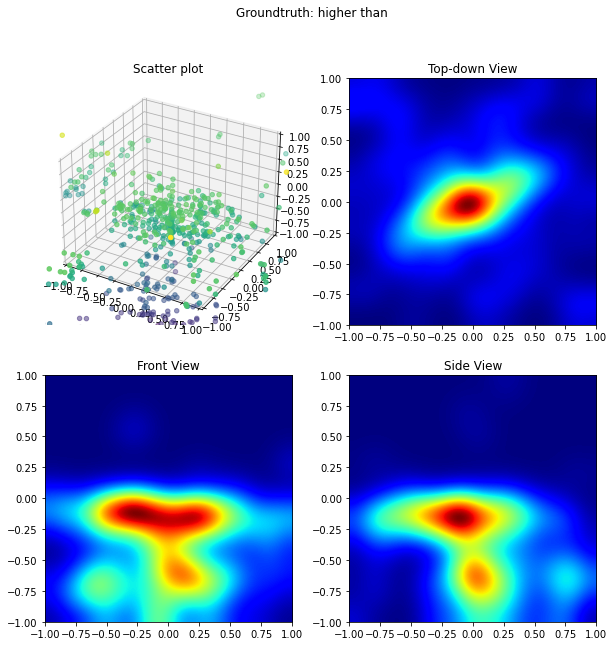

In [21]:
%matplotlib inline
scatter_heat_plot(target_scatter_list, 1, f'Groundtruth: {relation_dict[selected_edge_type]}', sigma = 64)

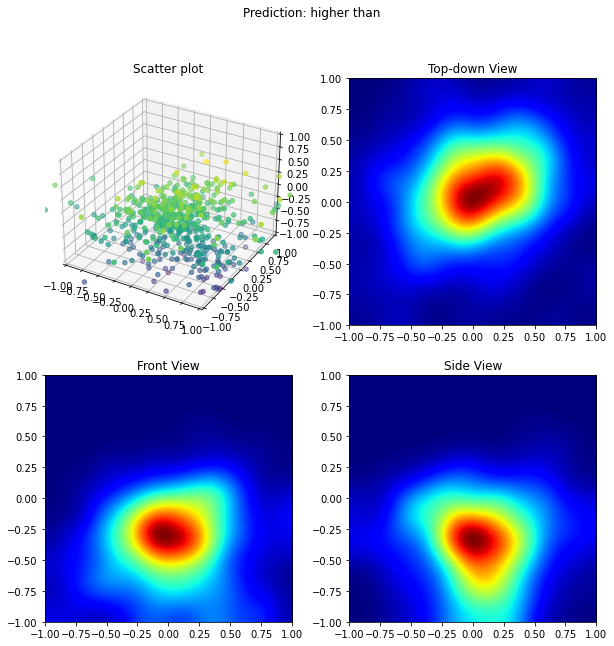

In [20]:
scatter_heat_plot(score_scatter_list, 1, f'Prediction: {relation_dict[selected_edge_type]}', sigma = 64)

id	type
0	in the room
1	supported by
2	left
3	right
4	front
5	behind
6	close by
8	bigger than
9	smaller than
10	higher than
11	lower than
12	same symmetry as
13	same as
14	attached to
15	standing on
16	lying on
17	hanging on
18	connected to
19	leaning against
20	part of
21	belonging to
22	build in
23	standing in
24	cover
25	lying in
26	hanging in